# Mesurement error mitigation

<p>
<font size=4 color="#0f62fe">IBM Quantum Partner Technical Enablement Team</font>
<p>

## Overview

Here we show how to mitigate measurements on IBM Quantum systems in a scalable manner using the [M3 package](https://qiskit.org/documentation/partners/mthree/).

## Summary

For short-depth near term applications, measurement errors can greatly affect the computation of expectation values and other quantities on today's quantum systems.  M3 allows one to easily mitigate these measurement errors up to numbers of qubits that are otherwise out of reach for other mitigation methods.  Mitigation invloves three steps:

1. Construct a mitigator targeting a backend (`backend`).

```python
import mthree
mit = mthree.M3Mitigation(backend)
```

2. Use the mitigator to calibate over a list of physical qubits (`qubits`) measured


```python
mit.cals_from_system(qubits)
```

3. Generate a corrected set of quasiprobabilities from a given set of noisy counts data `raw_counts`:

```python
quasi_probs = mit.apply_correction(raw_counts, qubits)
```

These quasiprobabilities can then be used directly to compute expectation values.  A complete users guide can be found in the [M3 documentation](https://qiskit.org/documentation/partners/mthree).

## Frontmatter

In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector, hellinger_fidelity
from qiskit.test.mock import FakeMumbai

%config InlineBackend.figure_format = 'retina'
import mthree

In [2]:
IBMQ.load_account();

## Background

Although the power of quantum computation lies in the ability to create large amounts of entanglement and explore large swaths of Hilbert space, at the end of the day the result encoded in the terminal quantum state must be converted to classical information by meauring the qubits.  There is also the possibility of mid-circuit measurements, but we will not address those here.

Measurements are not perfect and have a non-negligible amount of error associated with them (taken from PRX Quantum 2, 040326 (2021))

<img src="imgs/meas-error-table.png" width=400 height=400 />

Each qubit of a quantum system has its own measurement error rates and, due to the differece in energy between the $|0\rangle$ and $|1\rangle$ states, there is a different error rate depending on which of these two states the qubit was supposed to be measured in

<img src="imgs/meas-errors-mumbai.png" width=600 height=400 />

Measurement errors take a given target bitstring, eg. `110011`, and probabalistically map it to other bitstrings that are close to the target in terms of Hamming distance.  Because a generic quantum circuit can yield any one of $2^{N}$ bitstrings, where $N$ is the number of qubits measured, characterizing this process requires prepping each computational basis state and measuring output bitstrings.  The resulting matrix that gets generated is called the assignment (A)-matrix (or T-matrix, or confusion matrix) (taken from PRX Quantum 2, 040326 (2021)):

<img src="imgs/full-A-matrix.png" width=500 height=500 />

The mitigation of measurement errors involves taking the above matrix $A$ and using it to solve the linear system of equations:

$$
A \vec{p}_{\rm ideal} = \vec{p}_{\rm noisy}
$$

for $\vec{p}_{\rm ideal}$, where $\vec{p}_{\rm noisy}$ is the raw output from the quantum computer in vector form, and $\vec{p}_{\rm ideal}$ is the target distribution representing no measurement errors, but still includes other sources of imperfection such as gate errors.

Since computing the full A-matrix requires $2^{N}$ circuits, it does not scale beyond a handful of qubits.  To get around this we will assume that the measurement error one one qubit is not affected by other qubits; there is no correlation between qubit readouts.  With this approximation, which is quite valid on IBM Quantum systems, it is possible to construct the A-matrix using as few as two circuits. While this is great progress, the dimensions of the A-matrix still grow as $2^{N}$ and therefore constructing the matrix is still prohibatively expensive.  Here we will use a method that bypasses these limitations, and can scale well beyond conventional methods: [PRX Quantum 2, 040326 (2021)](https://doi.org/10.1103/PRXQuantum.2.040326).

Depending on the solution method, the output $\vec{p}_{\rm ideal}$ is not guarenteed to be a physical probability vector.  Rather it is usually a vector of quasiprobabilities; a distribution that contains negative values but still sums to one.  Luckily this does not matter when computing expectation values, and we can use these quasiprobabilities directly in our calculations.

## Expectation values

Expectation values of Hermitian operators are the observables that can be measured for a quantum state.  Given that expectation values correspond to averages, formally an expectation value is the value that one would get by measuring a given operator infinity many times and averaging over the results of these measurements.  In practice one is limited to a finite number of samples from a given state and as such expectation values computed from a quantum computer are necessarily approximations to the true value; the precision of the computed value improving as $1/\sqrt{\rm samples}$.

IBM Quantum systems, like the vast majority of quantum architectures, can only measure in a single basis called the "computational basis" that defines the z-axis in the Bloch sphere representation of a single-qubit quantum state.

<img src="imgs/empty-bloch.png" width=400 height=400 />

Because we are able to measure only in the computational basis, expectation values must be over only those operators that are diagonal in this basis.  We will also assume that the spectral radius of the oprators is one, and that any coefficients can be multiplied later in via classical post-processing.  Many operators of interest already statisfy this:

$$
Z = \begin{bmatrix} 1 & 0 \\ 0 & -1\end{bmatrix}; \ \ I = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}; P_{0} = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix}; P_{1} = N = \begin{bmatrix} 0 & 0 \\ 0 & 1\end{bmatrix};
$$

and others do not:

$$
X = \begin{bmatrix} 0 & 1 \\ 1 & 0\end{bmatrix}; \ \ Y = \begin{bmatrix} 0 & -i \\ i & 0\end{bmatrix}; 
$$

If we want to measure non-diagonal operators on qubits we need to append additional operators to the circuit that rotate the eigenstates of the non-diagonal operator onto the computational basis states.

For the `X` operator this is done by appending a Hadamard gate `H` to the circuit that rotates the $|+x\rangle$ and $|-x\rangle$ states onto the $|0\rangle$ and $|1\rangle$ state, respectively.

<img src="imgs/bloch-xbasis.png" width=400 height=400 />

Similarly for the `Y` operator we can append an $S^{\dagger}$ gate to align the $|\pm y\rangle$ states with the corresponding x-axes, and then follow that up with a `H` gate as done above.

<img src="imgs/bloch-ybasis.png" width=400 height=400 />

### Computing expectation values

We now turn to the question of how to compute the expectation value of a given operator from data returned by the quantum computer.  Coming back to the BV circuit discussed earlier, we see that at the end of the algorithm all the qubits used for encoding the secret bitstring have a Hadamard gate followed by a measurement.  From our explaination above we see this to be nothing more than measuring each of the qubits in the x-basis. 

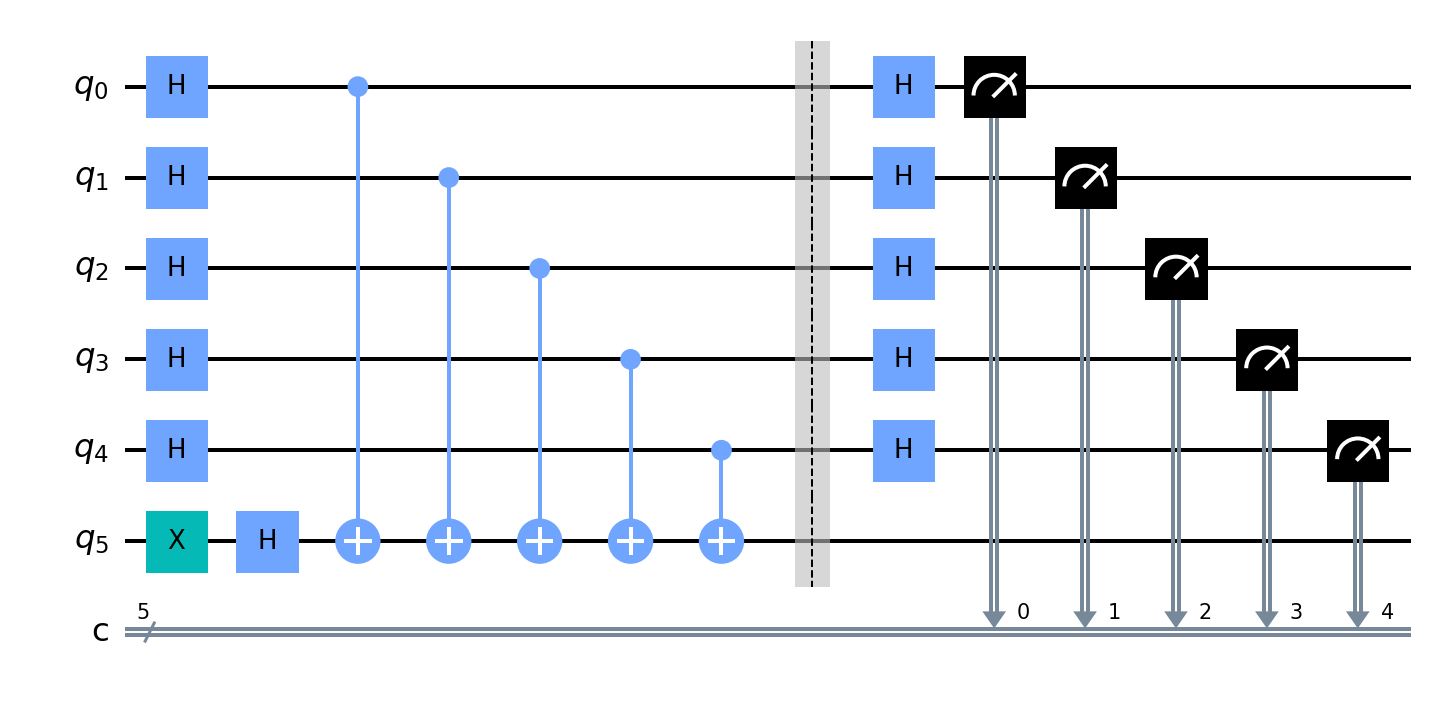

In [3]:
N = 6
qc_bv = QuantumCircuit(N, N-1)
qc_bv.x(N-1)
qc_bv.h(range(N))
qc_bv.cx(range(0,N-1),N-1)
qc_bv.barrier()
qc_bv.h(range(N-1))
qc_bv.measure(range(N-1), range(N-1))
qc_bv.draw('mpl')

In [4]:
backend = FakeMumbai()

In [5]:
trans_qc = transpile([qc_bv]*10, backend, optimization_level=3, initial_layout=[3, 0, 4, 2, 7, 1])
depths = np.array([circ.depth() for circ in trans_qc])
idx = np.where(depths == min(depths))[0][0]
best_qc = trans_qc[idx]

In [6]:
shots = 4000
z_counts = backend.run(best_qc, shots=shots).result().get_counts()

In [7]:
print(z_counts)

{'01000': 1, '11000': 1, '11100': 5, '10010': 1, '00010': 2, '00111': 55, '10100': 3, '10001': 3, '10011': 6, '01110': 12, '00101': 4, '10101': 2, '01101': 3, '10111': 134, '00001': 87, '11010': 7, '01011': 14, '00000': 22, '11001': 7, '00110': 4, '11101': 94, '00011': 56, '11110': 205, '11111': 2964, '10110': 29, '01001': 3, '11011': 105, '01111': 171}


Having applied the rotation gates at the end of the circuit, we left with computing the expectation value of the operator $\langle ZZZZZ\rangle$.  Let us take the bitstring `'10110'` as an explciit example.  First we compute the probability of being found in that state:

In [8]:
prob = z_counts.get('10110', 0) / shots
prob

0.00725

Next we need to determine the coefficient that multiples this probability.  Because the total operator is composed using the tensor product of diagonal operators, in this case $Z_{N-1}\otimes\dots\otimes Z_{0}$ (per the IBM bit-ordering convention) we can obtain this value directly from the eigenvalues (diagonal elements) of the sub-matrices specified by the bitstring.

Defining $z_{0}=Z[0,0]=1$ and $z_{1}=Z[1,1]=-1$ we have

In [9]:
z0 = 1
z1 = -1

coeff = z1*z0*z1*z1*z0 #10110
coeff

-1

Then the contribution to the expectation value from that bitstring is simply

In [10]:
coeff*prob

-0.00725

This procedure can be extended to all elments of the counts

In [11]:
exp_val = 0
operator = 'ZZZZZ'
operator_dict = {'Z': [1, -1]}
for key, val in z_counts.items():
    prob = val / shots
    coeff = 1
    for idx, bit in enumerate(key):
        coeff *= operator_dict[operator[idx]][int(bit)]
    exp_val += coeff * prob
print('Expectation value:', exp_val)    

Expectation value: -0.597


We can now include the possibility of using a collection of diagonal operators:

In [12]:
def expectation_value(counts, operator):
    """Compute expectation value for a given operator represented by a string
    and a dictionary of counts data.
    
    Parameters:
        counts (dict): Dictionary of counts.
        operator (str): A diagonal Hermitian operator.
        
    Returns:
        float: Expectation value.
    """
    exp_val = 0
    shots = sum(counts.values())
    operator_dict = {'Z': [1, -1], 'I': [1, 1], '0': [1, 0], '1': [0, 1]}
    for key, val in counts.items():
        prob = val / shots
        coeff = 1
        for idx, bit in enumerate(key):
            coeff *= operator_dict[operator[idx]][int(bit)]
        exp_val += coeff * prob
    return exp_val

In [13]:
expectation_value(z_counts, 'IIIII')

1.0

Although we have focused on probabilties, the above expectation value routine is equally valid if we input quasiprobabilities in place of `counts` (provided they are both represented by a Python dictionary).  Therefore the introduction of measurement mitigation to routines that compute expectation values is nomially a very simple task.

## Matrix-free Measurement Mitigation (M3)

Here we will see how to use the M3 measurement mitigation method.  M3 is not a part of Qiskit and must be installed separately:

```bash
pip install mthree
```

Qiskit itself contains [a collection of methods](https://qiskit.org/documentation/apidoc/mitigation.html) that explicitly contruct the A-matrix but none the less might be valuable for small numbers of qubits.  However, this functionality is deprecated, and is not maintained.  M3 gets around the explicit construction of the full $2^{N}$ A-matrix via a information preserving truncation step (taken from PRX Quantum 2, 040326 (2021))

<img src="imgs/m3-truncation.png" width=900 height=400 />

that reduces the dimensionality to be equal to the number of unique bit-strings  in the noisy output distribution.  If the number of unique bit-strings is itself too large for explicit matrix construction then M3 will exploit the structure of the A-matrix to efficiently solve the linear system via matrix-free iterative methods.  This all sounds complicated, however the actual usage of M3 is strightforward and best demonstrated via examples. 

### Simple M3 example

Here we look at a simple example of a 12 qubit circuit that maps directly onto a linear topology.  We begin here as there is there is no additional qubit permutations from the SWAP mapper. 

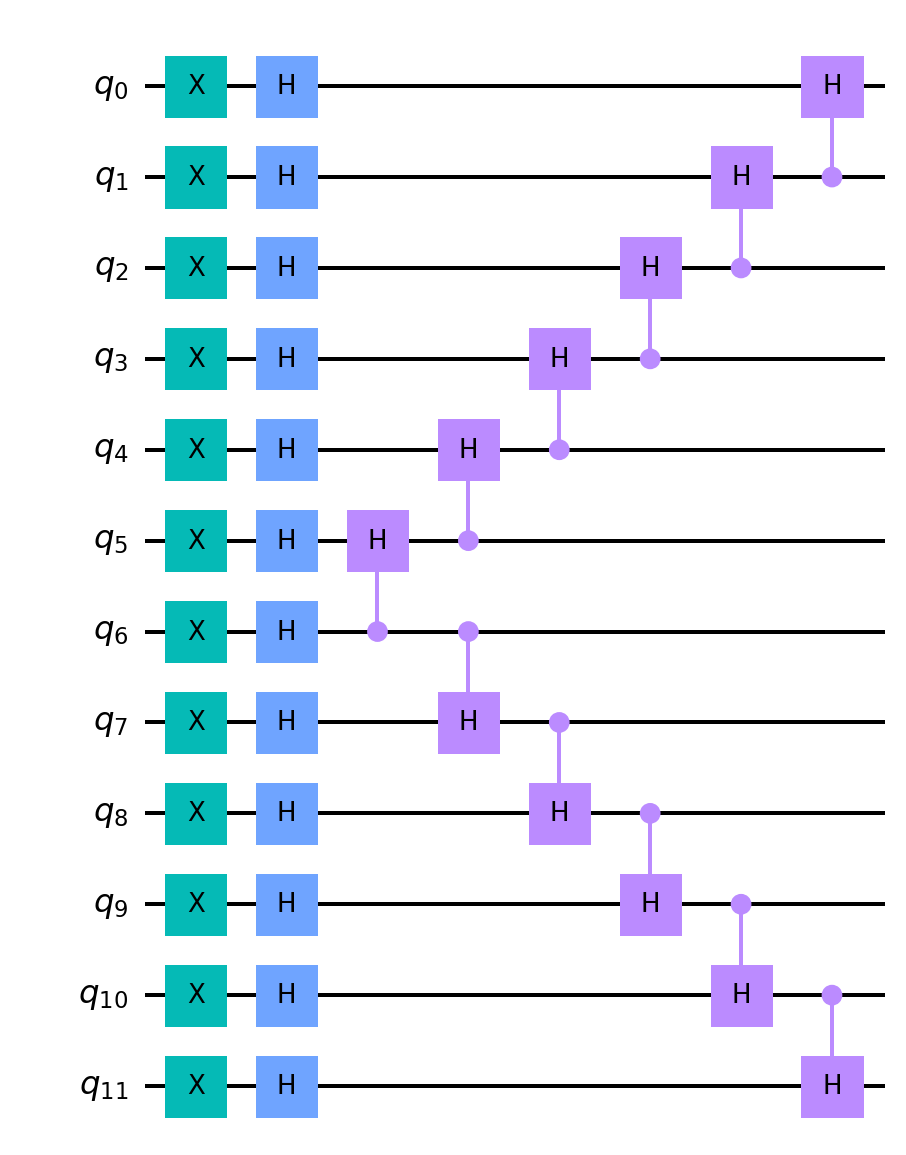

In [14]:
qubits = [1, 4, 7, 10, 12, 13, 14, 11, 8, 5, 3, 2]

N = 12
qc = QuantumCircuit(N)
qc.x(range(0, N))
qc.h(range(0, N))
for kk in range(N//2,0,-1):
    qc.ch(kk, kk-1)
for kk in range(N//2, N-1):
    qc.ch(kk, kk+1)
qc.draw('mpl', fold=-1)

In order to gauge the improvement from measurement mitigation we first compute the ideal output distribution from the statevector

In [15]:
state_vec = Statevector.from_instruction(qc)
ideal_prob = state_vec.probabilities_dict()

and evaluate the expectation value for the default all Z's expectation value using our `expectation_value` code above.

In [16]:
expectation_value(ideal_prob, 'Z'*12)

0.44628906249999983

Migition of measurement errors using M3 involves three steps:

1. Create a measurement mitigator that targets the system of interest.


2. Calibrate the mitigator over the physical qubits measured, or all qubits, if so desired.


3. Take the raw noisy counts data from one or more circuits and corrected it with the mitigator which returns quasiprobabilities.


Here we do Step #1 and create a mitigator targeting our backend:

In [17]:
mit = mthree.M3Mitigation(backend)

For Step #2 we need to tell the mitigator which qubits we are using so that it can calibrate their error rates.  If we do not specify the qubits it will calibrate all device qubits.  (Because we are using a noisy simulator, here we select `method='independent'` so that the calibrate involves many one-qubit circuits as opposed to larger ones.  This saves a lot of time.)

In [18]:
mit.cals_from_system(qubits, method='independent')

We now need to get some actual data to work with so let us now append measurements to our circuit above, transpile it, and run it on the target backend.  Note that as we have pre-arranged things so that the problem matches the system topology, and we do not benefit from block-collection, so we do not need to run `optimization_level=3` here.

In [19]:
qc_plus_meas = qc.measure_all(inplace=False)

In [20]:
trans_qc = transpile(qc_plus_meas, backend)
raw_counts = backend.run(trans_qc, shots=10000).result().get_counts()

We can now see what the raw expectation value equates to on this backend.

In [21]:
expectation_value(raw_counts, 'Z'*12)

0.05459999999999994

To get the mitigated quasiprobabilities, Step #3 above, we need to `apply_correction` to our `raw_counts` using the list of measured qubits to specify the physical qubits that correspond to the elements of the bit-strings.

In [22]:
quasi_probs = mit.apply_correction(raw_counts, qubits)

We can use our `expectation_value` code to directly compute the expectation value based on this corrected distribution.

In [23]:
expectation_value(quasi_probs, 'Z'*12)

0.14592727116993148

### Mitigating transpiled circuits

We have seen that SWAP mapping (transpiling) a circuit nominally permutes the assignment of qubits at the end of a circuit from the `initial_layout` that was supplied by the user or autogenerated.  Going back to our GHZ example:

In [24]:
N = 6
qc2 = QuantumCircuit(N)
qc2.h(0)
qc2.cx(0,range(1, N))
qc2.measure_all()

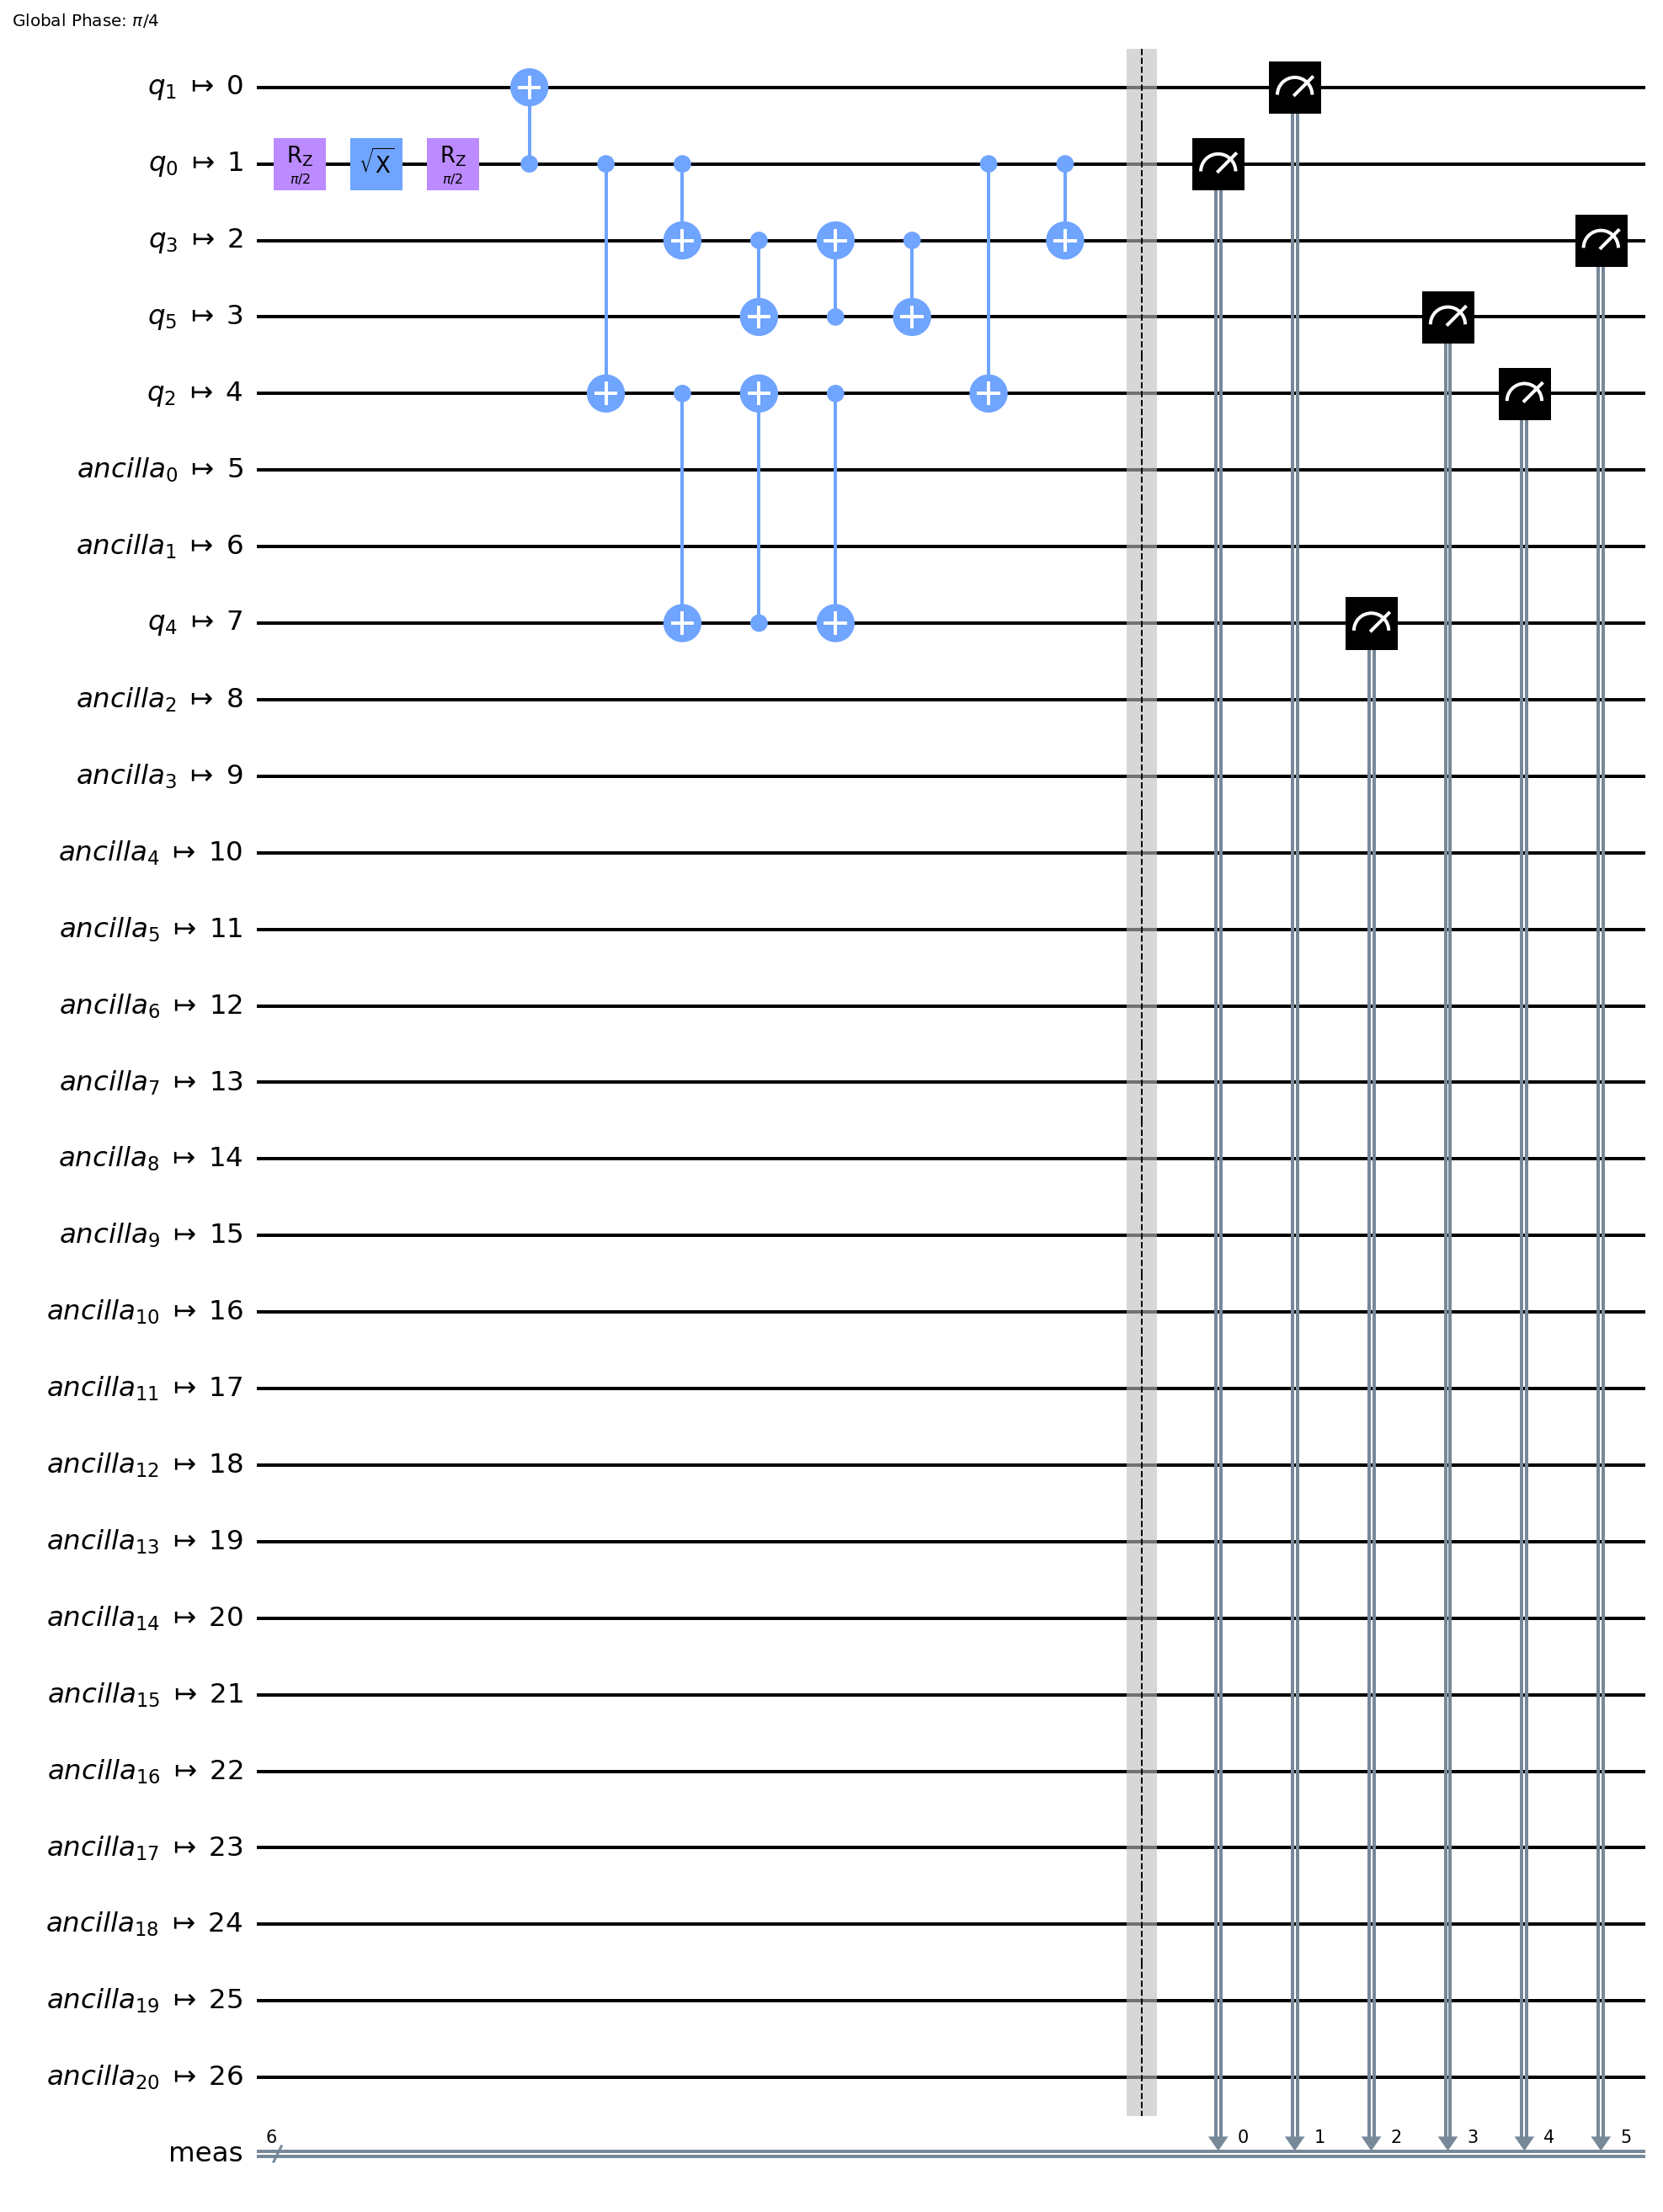

In [25]:
trans_qc2 = transpile(qc2, backend, initial_layout=[1, 0, 4, 2, 7, 3], seed_transpiler=12)
trans_qc2.draw('mpl', fold=-1)

we see that the physical qubits that correspond to the measured virtual qubits does not match that of the initial layout.  In the example above we started with the mapping `[1, 0, 4, 2, 7, 3]` but ended up with `[1, 0, 7, 3, 4, 2]`.  Because each qubit has its own measurement error rate, it is important to track these permutations and account for them in the mitigation process.  Qiskit has no way of doing this outside of drawing the circuit and looking to see where the measurements map to.  M3 will compute this tracking for you

In [26]:
final_map = mthree.utils.final_measurement_mapping(trans_qc2)
final_map

{1: 0, 0: 1, 7: 2, 3: 3, 4: 4, 2: 5}

that tells you which physical qubit maps to which bit in the bit-string.  In this case `1->0`, `0->1`, `7->2`, etc. We will use this map to calibrate our mitigator and perform the correct mitigation.  First the raw results:

In [27]:
raw_counts2 = backend.run(trans_qc2, shots=10000).result().get_counts()

In [28]:
expectation_value(raw_counts2, 'Z'*6)

0.6396

Now make a generator and calibrate only those qubits in `final_map`:

In [29]:
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(final_map, method='independent')

Apply correction and see how good we did:

In [30]:
quasi_prob2 = mit.apply_correction(raw_counts2, final_map)

In [31]:
expectation_value(quasi_prob2, 'Z'*6)

0.8257996459173018

### Getting a probability distribution

For those who would like to get the closest probability distribution, in the sense of $L^{2}$-norm one can use the `nearest_probability_distribution` method of the quasiprobabilites.

In [32]:
quasi_prob2.nearest_probability_distribution()

{'110110': 5.009010576411074e-06,
 '011000': 1.8843186291265155e-05,
 '101110': 2.0627379961496512e-05,
 '011101': 3.437488208836698e-05,
 '010010': 4.683476333171993e-05,
 '011100': 5.177510947031782e-05,
 '011011': 5.718764160381869e-05,
 '001111': 5.800433516431424e-05,
 '010101': 6.157109319418431e-05,
 '001100': 7.983259391098423e-05,
 '001010': 0.0001051145842422604,
 '010100': 0.0001076663409349449,
 '011010': 0.00011312010905190054,
 '100110': 0.00012893851975533167,
 '010001': 0.00014018582043785142,
 '010110': 0.00014162590979997596,
 '010011': 0.0001512163970507106,
 '111000': 0.0001672832442739644,
 '101100': 0.00016961028460834711,
 '000011': 0.00020362383063453273,
 '001001': 0.00025116135809855614,
 '110101': 0.00027553532855203956,
 '111010': 0.0005461482842454649,
 '101000': 0.0006559823776728074,
 '000100': 0.0008078511257783652,
 '101011': 0.001844792545360524,
 '010000': 0.0021633182524277337,
 '001000': 0.002315084088984433,
 '000001': 0.0029400327803077607,
 '1100

## Final notes

1. Typically you know all the qubits you are using ahead of time, and therefore the calibrate procedure need only be done once by passing the entire set of qubits to `cals_from_system` (can be in the form of a list of final mappings.


2. One can correct multiple circuits at once by supplying a list of circuits and  measured qubits or mappings to `apply_correction`.


3. M3 has a host of other features detailed in the documentation: https://qiskit.org/documentation/partners/mthree

In [33]:
import qiskit.tools.jupyter
%qiskit_version_table